In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ortools.linear_solver import pywraplp

In [55]:
def lp_solve(version="cost"):
    """Solve the UC problem using LP. With 'cost', minimise cost. With 'CO2', minimise CO2."""

    solver = pywraplp.Solver.CreateSolver('GLOP')
    
    # notice that nothing in this is hard-coded, ie we can re-run if needed
    # on a new csv. (The exception is the number of hours in a day.)
    
    generator_info = pd.read_csv("generator_info.csv", delimiter=",")
    demand = np.loadtxt("demand.csv")
    solar_curve = np.loadtxt("solar_curve.csv")
    ngenerators = len(generator_info["name"])
    nhours = 24 # hard-coded as unlikely to change
    
    CO2 = generator_info["CO2 (tons/MW)"].values
    cost = generator_info["cost (EUR/MW)"].values

    # all the generators have lower and upper bounds
    LB = generator_info["lower_bound (MW)"].values
    LB = np.broadcast_to(LB, (nhours, ngenerators)).astype(float)
    UB = generator_info["upper_bound (MW)"].values
    UB = np.broadcast_to(UB, (nhours, ngenerators)).astype(float)
    # used only in calculating relative values for plotting
    UB_per_generator = generator_info["upper_bound (MW)"].values 

    for i in range(ngenerators):
        if generator_info["type"][i] == "solar":
            # solar generators' production is scaled by a factor in
            # [0, 1] according to hour.  we apply this here to scale
            # the max production for any solar generators.
            UB[:, i] = UB[:, i] * solar_curve
    
    print(generator_info)
    plt.plot(demand)
    plt.ylabel("Demand (MW)")
    plt.close()
    plt.plot(solar_curve)
    plt.ylabel("Solar curve")
    plt.close()
    
    # X are the decision variables. This also sets the box
    # constraints. Notice we give them names (strings) such as "X[0,
    # 0]" but since this is a list of lists, we *use* them by
    # referring to eg X[0][0]
    X = [[solver.NumVar(LB[i,j], UB[i,j], name=f'X[{i}, {j}]')
          for j in range(ngenerators)]
         for i in range(nhours)]

    # Set all solid-fuel generators to be constant: each equal to
    # first. (Common error: this is not the same as optimising for
    # hour 0 and then using the solid-fuel value found for hour 0 as a
    # fixed value for later hours. The latter would give sub-optimal
    # results.)
    
    # start at x_i1 == x_i0, then x_i2 == x_i0, etc
    for i in range(1, nhours): 
        for j in range(ngenerators):
            if generator_info["type"][j] == "solid":
                solver.Add(X[i][j] == X[0][j],
                           name=f"solid {i,j} constant")

    # supply = demand
    for i in range(nhours):
        solver.Add(sum(X[i][j] for j in range(ngenerators))
                   == demand[i],
                   name=f"supply == demand {i}")

                          
    # create minimisation objective 
    if version == "cost":
        solver.Minimize(sum(cost[j] * X[i][j] for i in range(nhours) for j in range(ngenerators)))
    elif version == "CO2":
        solver.Minimize(sum(CO2[j] * X[i][j] for i in range(nhours) for j in range(ngenerators)))

        
    # solve and interpret
    result = solver.Solve()

    d = {
        solver.OPTIMAL: "OPTIMAL",
        solver.INFEASIBLE: "INFEASIBLE",
        # ABNORMAL likely to do with imprecision
        # https://github.com/google/or-tools/issues/1868
        solver.ABNORMAL: "ABNORMAL"
        # there are other results but I have never seen them
    }

    if result != solver.OPTIMAL:
        raise ValueError(f"System not solved to optimality: d[result]")

    opt = solver.Objective().Value()

    # I want the solution in a Numpy array
    x = np.zeros_like(UB, dtype=float)
    for i in range(nhours):
        for j in range(ngenerators):
            x[i,j] = X[i][j].solution_value()
            
    total_cost = (cost.reshape((1, 12)) * x).sum()
    total_CO2 = (CO2.reshape((1, 12)) * x).sum()

    # the generators' *relative* values could also be interesting to
    # plot. I am taking their value relative to their max. (One might
    # prefer to take their value relative to their allowable range
    # (min, max). I prefer this way, but it is subjective.)
    x_rel = x / UB_per_generator

    
    # return everything of interest, including the solver
    # since we will use that in sensitivity analysis
    return x, x_rel, opt, solver, total_cost, total_CO2


In [56]:
x_cost, x_rel_cost, obj_cost, solver_cost, total_cost_cost, total_CO2_cost = lp_solve()

   name   type  lower_bound (MW)  upper_bound (MW)  cost (EUR/MW)  \
0     A  hydro              10.0             100.0            1.4   
1     B  hydro              10.0              80.0            1.4   
2     C  hydro              10.0              60.0            1.4   
3     D  hydro               1.0              10.0            1.4   
4     E  solid             100.0             900.0            4.4   
5     F  solid             100.0             600.0            4.4   
6     G  solid              10.0             100.0            4.4   
7     H    gas             100.0             400.0            9.1   
8     I    gas              50.0             300.0            9.5   
9     J  solar               0.0              20.0            5.4   
10    K  solar               0.0              60.0            5.4   
11    L  solar               0.0              30.0            5.4   

    CO2 (tons/MW)  
0           0.024  
1           0.024  
2           0.024  
3           0.024  
4 

In [57]:
def viz_sol(x, filename=None):
    plt.pcolormesh(x, edgecolors='k', linewidth=2)
    ax = plt.gca()
    ax.invert_yaxis()
    plt.colorbar()
    plt.ylabel("Hour")
    plt.xlabel("Generator")
    
    ax.grid(which="minor", color="b", linestyle="-", linewidth=3)
    
    for edge, spine in ax.spines.items():
        spine.set_visible(False)
    
    plt.tight_layout()
    plt.show()
    if filename is not None:
        plt.savefig(filename)
    plt.close()

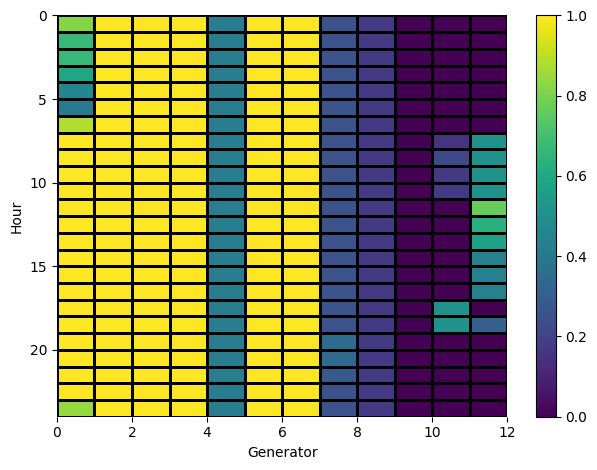

In [58]:
viz_sol(x_rel_cost)

In [48]:
def print_solution(solver):
    for v in solver.variables():
        print(f"{v.name()} = {v.solution.value():.5}")